In [1]:
#Region proposal Detection By Hadi Abdelmawla
# USAGE
# python region_proposal_detection.py --image beagle.png

# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression

import numpy as np
import argparse
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass



In [2]:
# Example execution
args = dict()
args['image'] = 'beagle.png' # in order to change to the other photo just type
#test.jpg
args['method'] = 'fast'   # Other choice is quality
args['conf'] = 0.9
args['filter'] = None

In [3]:
#this is code that was given
def selective_search(image, method):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)

	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()

	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()

	# run selective search on the input image
	rects = ss.process()

	# return the region proposal bounding boxes
	return rects




In [4]:
#this is also code that was given
# speed-up using multithreads
#cv2.setUseOptimized(True);
#cv2.setNumThreads(4);

args['method'] = 'fast'   # Other choice is quality


# Change to the test image for evaluation args['image'] = 'test.jpg'


# load the input image from disk and grab its dimensions
image = cv2.imread(args['image'])
(H, W) = image.shape[:2]

# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	args["method"]))


e1 = cv2.getTickCount()
rects = selective_search(image, method=args["method"])
e2 = cv2.getTickCount()

time = (e2 - e1)/ cv2.getTickFrequency()

print( time, "seconds")


print("[INFO] {} regions found by selective search".format(len(rects)))





[INFO] performing selective search with 'fast' method...
0.973183511 seconds
[INFO] 922 regions found by selective search


In [230]:
default = (240,240) # this is to set default to 240 can also be changed to 128

In [231]:
strides = np.arange (1, 11, 1)

In [50]:
#this is code that was given to us
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
	if w / float(W) < 0.1 or h / float(H) < 0.1:
		continue

	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224))

	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, w, h))
    
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))

[INFO] proposal shape: (534, 224, 224, 3)


In [9]:
#rewrote the above into a function as asked for in the hw above part A
def reimage (rects, image, defaultSize):
    # initialize the list of region proposals that we'll be classifying
    # along with their associated bounding boxes
    proposals = []
    boxes = []

# loop over the region proposal bounding box coordinates generated by
# running selective search
    for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
        if w / float(W) < 0.1 or h / float(H) < 0.1:
            continue

	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
        roi = image[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, defaultSize)

	# further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, w, h))
    
# convert the proposals list into NumPy array and show its dimensions
    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    return proposals, boxes

In [10]:
#rewrote the function above in order to satisfy part A
def winapproach (strides, image, fixedwin): #strides has to be in the form
    #of (y,x) with x being the stride length in the x direction and y being 
    #the stride length in the y direction
    #fixed win is the fixed size windows
    # initialize the list of region proposals that we'll be classifying
    # along with their associated bounding boxes
    proposals = []
    boxes = []
    newx = 0
    newy = 0
    xlim = image.shape[1] - fixedwin[1] #to find the limit in the x direction
    #subtract the shaped of the image by the  direction of the fixedwin
    ylim = image.shape[0] - fixedwin[0]
    xrange = int (xlim / strides) #then divide it by the stride in order to know
    #how many times the fixed win fits in the image given the stride length
    yrange = int(ylim / strides)
# loop over the region proposal bounding box coordinates generated by
# running selective search
    for x in range (0, xrange):
        newx = newx + strides
        newy=0
        for y in range (0, yrange):
            
            roi = image[newy:fixedwin[0] + newy, newx:fixedwin[1] + newx]
#Now the roi has starting coordinates of 0,0 for the first iteration then it 
#moves by whatever the strid length is for each iteration the corresponding 
#box is the whatever the staring coordinate plus the fixed window size
            #print(newx,newy)
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            roi = cv2.resize(roi, (224,224))
            
            newy = newy + strides
            roi = img_to_array(roi)
            roi = preprocess_input(roi)
            proposals.append(roi)
            boxes.append((newx, newy, fixedwin[1], fixedwin[0]))
    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    return proposals, boxes
    

In [11]:
p = dict()
b = dict()
s = 1
# now run the above function with window size 128 and strides 1,2,4...
mylist = (0,1,2,3,4,5)
for i in mylist:
    p[i], b[i] = winapproach(s, image, default)
    print(s)
    s = s *2
#p[1], b = winapproach(s, image, default)
#s=4
#p[2],b = winapproach(s, image, default)

[INFO] proposal shape: (24960, 224, 224, 3)
1
[INFO] proposal shape: (6240, 224, 224, 3)
2
[INFO] proposal shape: (1560, 224, 224, 3)
4
[INFO] proposal shape: (384, 224, 224, 3)
8
[INFO] proposal shape: (96, 224, 224, 3)
16
[INFO] proposal shape: (24, 224, 224, 3)
32


In [41]:
default = (224, 224) # this can be changed to 128 but it was kept at 224 
#because 128 required a lot of computing from the server and the server is
#overloaded right now
prop, boxs = reimage(rects,image, default )
rectan = selective_search(image, 'quality') # now run everything again with 
#quality instead of fast
theprop, theboxs = reimage(rectan,image, default )

[INFO] proposal shape: (534, 224, 224, 3)
[INFO] proposal shape: (2354, 224, 224, 3)


[0 1 2 3 4 5 6 7]
534
[0 1 2 3 4 5 6 7]


<BarContainer object of 8 artists>

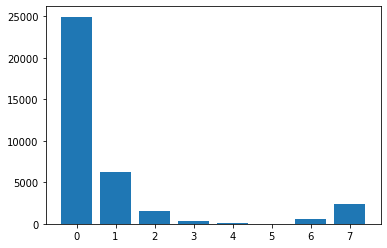

In [13]:
#this is the graph for part b
thelist = np.arange(0,8)
print(thelist)
h = dict()
amountofboxes = dict()
for i in mylist:
    h[i] = (p[i].shape)
    amountofboxes[i] = int (h[i][0])

#print (amountofboxes.shape())
z = prop.shape
a = theprop.shape
print (z[0])
amountofboxes[6] = z[0]
amountofboxes[7] = a[0]
keys = thelist

print (keys)
values = amountofboxes.values()
plt.bar(keys, values)

In [16]:
#this is code that was given
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")
    
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

[INFO] loading ResNet...


In [225]:
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
#created this into a function to return predictions and time it takes for part F
def classifiying(someproposals):
    print("[INFO] classifying proposals...")
    startTime = cv2.getTickCount() # get the time it takes to do model.predict
    preds = model.predict(someproposals)
    endTime = cv2.getTickCount()
    timePredict = (e2 - e1)/ cv2.getTickFrequency()
    preds = imagenet_utils.decode_predictions(preds, top=1)
    return preds, timePredict

In [232]:
#calling the above function
dapredsqual, qualTime = classifiying(theprop)
dapredsfast, fastTime = classifiying(proposals)

[INFO] classifying proposals...
[INFO] classifying proposals...


In [39]:
# Setting this will limit the search to just one category
labelFilters = ['beagle']


In [26]:
#this is code that was given
# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
	(imagenetID, label, prob) = p[0]
	print (label)

	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it
	if labelFilters is not None and label not in labelFilters:
		continue

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		(x, y, w, h) = boxs[i]
		box = (x, y, x + w, y + h)

		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L



beagle
plane
redbone
basenji
English_foxhound
beagle
whippet
clog
beagle
basset
Chihuahua
beagle
platypus
paper_towel
French_loaf
hourglass
quill
patas
face_powder
beagle
paper_towel
beagle
clog
kit_fox
cradle
beagle
Cardigan
clog
patas
beagle
Walker_hound
table_lamp
German_shepherd
proboscis_monkey
whippet
carton
basset
paper_towel
hourglass
violin
shower_curtain
paper_towel
Walker_hound
Saint_Bernard
otterhound
Windsor_tie
bloodhound
Dandie_Dinmont
toilet_seat
borzoi
beagle
beagle
clog
paper_towel
carton
English_foxhound
Walker_hound
bath_towel
beagle
beagle
carton
whippet
Saint_Bernard
fur_coat
beagle
beagle
kit_fox
English_foxhound
meerkat
beagle
beagle
microwave
whippet
hourglass
plane
English_foxhound
quill
carton
beagle
face_powder
Windsor_tie
Old_English_sheepdog
paper_towel
patas
beagle
basenji
quill
whippet
beagle
paper_towel
beagle
beagle
beagle
beagle
clog
Old_English_sheepdog
plane
Windsor_tie
fur_coat
Shetland_sheepdog
knee_pad
Norwegian_elkhound
binder
dhole
envelope
Fre

IndexError: list index out of range

In [151]:
#created the above function into a code with a conf variable for part d
def findlabels(preds, boxes, labelFilters, conf):
# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
    labels = {}

# loop over the predictions
    for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
        (imagenetID, label, prob) = p[0]
        print (label)

	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it
        if labelFilters is not None and label not in labelFilters:
            continue

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
        if prob >= conf:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
            print(i)
            if(i==540):
                return labels, box
            if(boxs[i]>((H,W))):
                continue
            (x, y, w, h) = boxs[i]

            box = (x, y, x + w, y + h)

		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
    return labels, box


In [158]:
#calling the above function for fast and .9 conf
labels, aftercofboxqual = findlabels(dapredsqual, theboxs, labelFilters, args['conf'])



Saint_Bernard
Walker_hound
carton
fur_coat
beagle
fur_coat
beagle
whippet
beagle
beagle
Rottweiler
beagle
patas
clog
Walker_hound
basenji
borzoi
carton
beagle
English_foxhound
Siamese_cat
plane
face_powder
clog
shower_curtain
patas
toilet_tissue
French_loaf
patas
beagle
29
Walker_hound
beagle
beagle
beagle
beagle
beagle
proboscis_monkey
patas
carton
paper_towel
beagle
beagle
beagle
whippet
English_foxhound
quill
Siamese_cat
clog
plane
beagle
49
kit_fox
patas
Arabian_camel
beagle
schipperke
patas
bloodhound
clog
hourglass
panpipe
beagle
carton
patas
Dandie_Dinmont
affenpinscher
beagle
65
beagle
clog
English_foxhound
plane
beagle
70
English_foxhound
patas
affenpinscher
binder
shower_curtain
paper_towel
beagle
redbone
paintbrush
gazelle
quill
rocking_chair
carton
toilet_seat
basenji
Rottweiler
beagle
87
beagle
beagle
beagle
90
beagle
clog
four-poster
paintbrush
paper_towel
fur_coat
paper_towel
shower_curtain
Walker_hound
quill
shower_curtain
panpipe
whippet
quill
Windsor_tie
basenji
binde

IndexError: list index out of range

In [108]:
#doing the same thing for quality and conf .9
thelabels, aftercofboxfast = findlabels(dapredsfast, boxes, labelFilters,args['conf'])


patas
Boston_bull
clog
clog
basset
quill
hourglass
hartebeest
quill
redbone
carton
paper_towel
meerkat
beagle
beagle
paper_towel
ski_mask
hourglass
whippet
French_loaf
clog
beagle
beagle
panpipe
beagle
guillotine
beagle
carton
beagle
hourglass
paper_towel
Petri_dish
quill
velvet
cradle
Cardigan
clog
beagle
face_powder
Walker_hound
patas
beagle
plane
whippet
paper_towel
gong
Walker_hound
wooden_spoon
carton
beagle
redbone
panpipe
brassiere
Rottweiler
beagle
clog
basenji
whippet
quill
beagle
Saluki
Band_Aid
English_foxhound
puck
proboscis_monkey
beagle
beagle
bloodhound
paper_towel
Walker_hound
beagle
Saint_Bernard
beagle
fur_coat
Windsor_tie
beagle
English_foxhound
beagle
beagle
pedestal
table_lamp
plane
black-and-tan_coonhound
beagle
paper_towel
beagle
basset
carton
plane
Sussex_spaniel
chow
English_foxhound
shower_curtain
beagle
Siamese_cat
hartebeest
beagle
redbone
beagle
beagle
beagle
beagle
Airedale
beagle
patas
patas
English_foxhound
beagle
Saluki
Walker_hound
patas
eggnog
Boston_

In [55]:
proposals_image = image.copy()
annotated_image = image.copy()
# turned the code that was given into a function
def finalpred(labels):
# loop over the labels for each of detected objects in the image
    for label in labels.keys():
	# clone the original image so that we can draw on it
        print("[INFO] showing results for '{}'".format(label))

	# loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
		# draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(proposals_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)


	# extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
        for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
            cv2.rectangle(annotated_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(annotated_image, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    return proposals_image, boxes


In [75]:
#called the above function for fast and quality
image_proposal, finalboxsqual = finalpred(labels)
image_proposalfast, finalboxsfast = finalpred(thelabels)

[INFO] showing results for 'beagle'
[INFO] showing results for 'beagle'


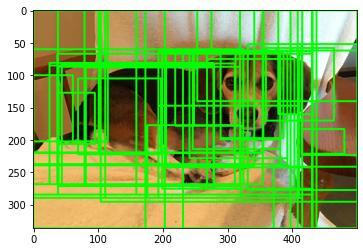

In [239]:
# show the results *before* applying non-maxima suppression, then
# clone the image again so we can display the results *after*
# applying non-maxima suppression
plt.imshow(cv2.cvtColor(image_proposal, cv2.COLOR_BGR2RGB))

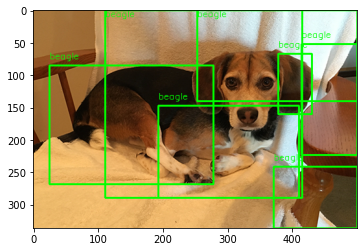

In [240]:
#this is code that was given
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

534


<BarContainer object of 8 artists>

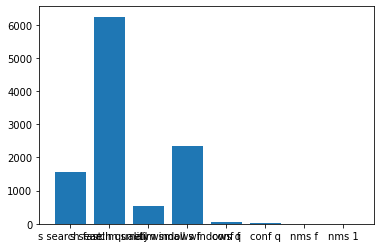

In [105]:
#this is the graph for part c
axisx = ('s search fast', 's search quality', 'elim small windows f', 
        'elim small windows q','conf f', 'conf q', 'nms f', 'nms 1')
print(prop.shape[0])

yaxis = (amountofboxes[2],amountofboxes[1],prop.shape[0],theprop.shape[0],
        len(thelabels['beagle']), len(labels['beagle']),finalboxsfast.shape[0],
        finalboxsqual.shape[0])
plt.bar(axisx, yaxis)

In [153]:
#now we adjust the conf to .7 for part d this is for fast
args['largeconf'] = 0.7
fastlabels, largeConfFast = findlabels(dapredsfast, boxes, labelFilters,args['largeconf'])



patas
Boston_bull
clog
clog
basset
quill
hourglass
hartebeest
quill
redbone
carton
paper_towel
meerkat
beagle
13
beagle
14
paper_towel
ski_mask
hourglass
whippet
French_loaf
clog
beagle
beagle
22
panpipe
beagle
24
guillotine
beagle
26
carton
beagle
28
hourglass
paper_towel
Petri_dish
quill
velvet
cradle
Cardigan
clog
beagle
37
face_powder
Walker_hound
patas
beagle
41
plane
whippet
paper_towel
gong
Walker_hound
wooden_spoon
carton
beagle
49
redbone
panpipe
brassiere
Rottweiler
beagle
54
clog
basenji
whippet
quill
beagle
Saluki
Band_Aid
English_foxhound
puck
proboscis_monkey
beagle
65
beagle
bloodhound
paper_towel
Walker_hound
beagle
70
Saint_Bernard
beagle
fur_coat
Windsor_tie
beagle
75
English_foxhound
beagle
77
beagle
pedestal
table_lamp
plane
black-and-tan_coonhound
beagle
83
paper_towel
beagle
85
basset
carton
plane
Sussex_spaniel
chow
English_foxhound
shower_curtain
beagle
Siamese_cat
hartebeest
beagle
redbone
beagle
beagle
beagle
100
beagle
101
Airedale
beagle
patas
patas
English_

In [152]:
#now run quality with the conf of .7
quallabels, largeCofQual = findlabels(dapredsqual, theboxs, labelFilters, args['largeconf'])


Saint_Bernard
Walker_hound
carton
fur_coat
beagle
fur_coat
beagle
6
whippet
beagle
beagle
9
Rottweiler
beagle
11
patas
clog
Walker_hound
basenji
borzoi
carton
beagle
English_foxhound
Siamese_cat
plane
face_powder
clog
shower_curtain
patas
toilet_tissue
French_loaf
patas
beagle
29
Walker_hound
beagle
31
beagle
beagle
beagle
34
beagle
35
proboscis_monkey
patas
carton
paper_towel
beagle
beagle
beagle
whippet
English_foxhound
quill
Siamese_cat
clog
plane
beagle
49
kit_fox
patas
Arabian_camel
beagle
53
schipperke
patas
bloodhound
clog
hourglass
panpipe
beagle
carton
patas
Dandie_Dinmont
affenpinscher
beagle
65
beagle
clog
English_foxhound
plane
beagle
70
English_foxhound
patas
affenpinscher
binder
shower_curtain
paper_towel
beagle
77
redbone
paintbrush
gazelle
quill
rocking_chair
carton
toilet_seat
basenji
Rottweiler
beagle
87
beagle
beagle
beagle
90
beagle
91
clog
four-poster
paintbrush
paper_towel
fur_coat
paper_towel
shower_curtain
Walker_hound
quill
shower_curtain
panpipe
whippet
quill


<BarContainer object of 2 artists>

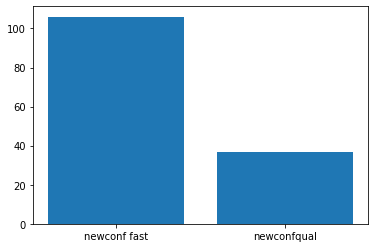

In [156]:
#This is the graph for part D
newXaxis = ('newconf fast', 'newconfqual')
newYaxis = (len(fastlabels['beagle']),len(quallabels['beagle']))
plt.bar(newXaxis, newYaxis)

In [224]:
#this is the code for part E where the IOU code is the same that we had 
#done in an earlier homework just reused for this one and fast with the percent
#of critical regions printed at the bottom
c=int(0)
critical_count = 0
noncritical_count = 0
j = thelabels['beagle'][0][0]

for i in thelabels['beagle']:

    if c >0:
        xA = max(j[0], i[0][0])
        yA = max(j[1], i[0][1])
        xB = min(j[2], i[0][2])
        yB = min(j[3], i[0][3])
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (j[2] - j[0] + 1) * (j[3] - j[1] + 1)
        boxBArea = (i[0][2] - i[0][0] + 1) * (i[0][3] - i[0][1] + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        j = i[0]

        if (iou<.25):
            critical_count = critical_count +1
        else:
            noncritical_count = noncritical_count +1

    c = c+1

total_amount = critical_count + noncritical_count
percent_critical = (critical_count/total_amount)*100
print('The total critical regions is:')
print(percent_critical)

The total critical regions is:
28.26086956521739


<BarContainer object of 2 artists>

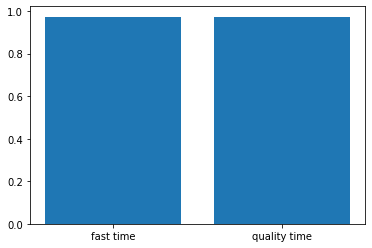

In [229]:
#this is the code for part F taking the time from model.predict above 
#and plotting it
partFyaxis = ('fast time', 'quality time')
partFxaxis = (fastTime, qualTime)
plt.bar(partFyaxis, partFxaxis)